# Part A

**Zhou Wei U2022264K**

In [1]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler

In [2]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Read Data

In [3]:
df = pd.read_csv('./full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [4]:
df['label'] = df['filename'].str.split('_').str[-2]

In [5]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

## Question 1

### a)

In [6]:
# Split and scale dataset
columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
    label_encoder = preprocessing.LabelEncoder()

    df['label'] = label_encoder.fit_transform(df['label'])

    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

    df_train2 = df_train.drop(columns_to_drop,axis=1)
    y_train2 = df_train['label'].to_numpy()

    df_test2 = df_test.drop(columns_to_drop,axis=1)
    y_test2 = df_test['label'].to_numpy() 

    return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

    standard_scaler = preprocessing.StandardScaler()
    df_train_scaled = standard_scaler.fit_transform(df_train)

    df_test_scaled = standard_scaler.transform(df_test)

    return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

In [7]:
no_epochs = 100
batch_size = 256
lr = 0.001

In [8]:
model = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])
    
    
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train,
                    epochs=no_epochs,
                    batch_size=batch_size,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                    validation_data=(X_test_scaled, y_test))

Epoch 1/100
499/499 [==============================] - 4s 9ms/step - loss: 0.6897 - accuracy: 0.5361 - val_loss: 0.6844 - val_accuracy: 0.5547
Epoch 2/100
499/499 [==============================] - 4s 7ms/step - loss: 0.6833 - accuracy: 0.5524 - val_loss: 0.6814 - val_accuracy: 0.5572
Epoch 3/100
499/499 [==============================] - 4s 8ms/step - loss: 0.6800 - accuracy: 0.5606 - val_loss: 0.6797 - val_accuracy: 0.5635
Epoch 4/100
499/499 [==============================] - 4s 7ms/step - loss: 0.6769 - accuracy: 0.5663 - val_loss: 0.6764 - val_accuracy: 0.5681
Epoch 5/100
499/499 [==============================] - 4s 8ms/step - loss: 0.6742 - accuracy: 0.5723 - val_loss: 0.6729 - val_accuracy: 0.5755
Epoch 6/100
499/499 [==============================] - 4s 8ms/step - loss: 0.6704 - accuracy: 0.5780 - val_loss: 0.6707 - val_accuracy: 0.5777
Epoch 7/100
499/499 [==============================] - 4s 8ms/step - loss: 0.6668 - accuracy: 0.5847 - val_loss: 0.6672 - val_accuracy: 0.5863

### b)

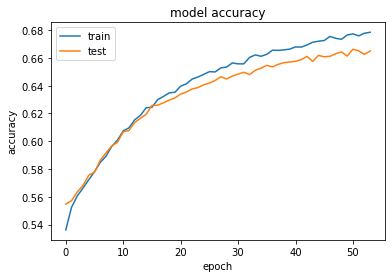

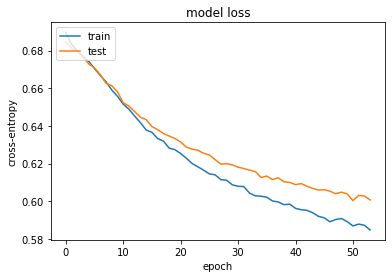

In [9]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

From the line plots above, the accuracies of the training and test data generally increase while the losses generally decrease as the number of epochs increases. 

Too many epochs can lead to overfitting of the training data and early stopping is used to overcome that. It can be observed that the validation error reached a minimum at the 51st epoch. Since the validation error of the subsequent 3 epochs is higher than the minimum, training of the network is stopped to prevent overfitting.

## Question 2

### a)

In [10]:
from tensorflow.keras.callbacks import Callback
        
class time_for_epoch(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [11]:
no_folds = 5
batch_sizes = [128, 256, 512, 1024]

In [12]:
from sklearn.model_selection import KFold

def train_batch():
    
    cv = KFold(n_splits=no_folds) 
    
    acc = []
    dur = []
    for train_idx, test_idx in cv.split(X_train):        
        
        train_idx_list = train_idx.tolist()
        test_idx_list = test_idx.tolist()
        X_train_cv, X_test_cv = X_train.iloc[train_idx_list], X_train.iloc[test_idx_list]
        X_train_cv_scaled, X_test_cv_scaled = preprocess_dataset(X_train_cv, X_test_cv)
        y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]
        
        accuracy = []
        duration = []
        for size in batch_sizes:
            model = Sequential([
                Dense(128, activation='relu'),
                Dropout(0.2),
                Dense(128, activation='relu'),
                Dropout(0.2),
                Dense(128, activation='relu'),
                Dropout(0.2),
                Dense(1, activation='sigmoid')])

            model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), 
                          loss='binary_crossentropy', 
                          metrics=['accuracy'])

            cb = time_for_epoch()

            history = model.fit(X_train_cv_scaled, y_train_cv,
                            epochs=no_epochs,
                            batch_size=size,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3), cb],
                            validation_data=(X_test_cv_scaled, y_test_cv))

            accuracy.append(history.history['val_accuracy'][-1])
            duration.append(cb.times[-1])
        
        acc.append(accuracy)
        dur.append(duration)
    
    cv_acc = np.mean(np.array(acc), axis = 0)
    cv_dur = np.mean(np.array(dur), axis = 0)
    
    return cv_acc, cv_dur

In [13]:
mean_acc, mean_time = train_batch()

Epoch 1/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6901 - accuracy: 0.5374 - val_loss: 0.6841 - val_accuracy: 0.5503
Epoch 2/100
798/798 [==============================] - 2s 2ms/step - loss: 0.6831 - accuracy: 0.5535 - val_loss: 0.6817 - val_accuracy: 0.5542
Epoch 3/100
798/798 [==============================] - 2s 2ms/step - loss: 0.6800 - accuracy: 0.5616 - val_loss: 0.6781 - val_accuracy: 0.5619
Epoch 4/100
798/798 [==============================] - 2s 2ms/step - loss: 0.6775 - accuracy: 0.5678 - val_loss: 0.6780 - val_accuracy: 0.5600
Epoch 5/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6739 - accuracy: 0.5725 - val_loss: 0.6748 - val_accuracy: 0.5707
Epoch 6/100
798/798 [==============================] - 2s 2ms/step - loss: 0.6707 - accuracy: 0.5781 - val_loss: 0.6726 - val_accuracy: 0.5761
Epoch 7/100
798/798 [==============================] - 2s 2ms/step - loss: 0.6666 - accuracy: 0.5861 - val_loss: 0.6690 - val_accuracy: 0.5827

Epoch 28/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6123 - accuracy: 0.6530 - val_loss: 0.6309 - val_accuracy: 0.6327
Epoch 29/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6130 - accuracy: 0.6525 - val_loss: 0.6314 - val_accuracy: 0.6282
Epoch 30/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6098 - accuracy: 0.6561 - val_loss: 0.6291 - val_accuracy: 0.6337
Epoch 31/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6099 - accuracy: 0.6546 - val_loss: 0.6276 - val_accuracy: 0.6375
Epoch 32/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6076 - accuracy: 0.6559 - val_loss: 0.6270 - val_accuracy: 0.6386
Epoch 33/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6069 - accuracy: 0.6588 - val_loss: 0.6272 - val_accuracy: 0.6375
Epoch 34/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6047 - accuracy: 0.6604 - val_loss: 0.6256 - val_accuracy:

Epoch 37/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6054 - accuracy: 0.6605 - val_loss: 0.6250 - val_accuracy: 0.6366
Epoch 38/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6047 - accuracy: 0.6602 - val_loss: 0.6236 - val_accuracy: 0.6425
Epoch 39/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6025 - accuracy: 0.6626 - val_loss: 0.6233 - val_accuracy: 0.6415
Epoch 40/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5997 - accuracy: 0.6686 - val_loss: 0.6236 - val_accuracy: 0.6421
Epoch 41/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6019 - accuracy: 0.6641 - val_loss: 0.6225 - val_accuracy: 0.6397
Epoch 42/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5989 - accuracy: 0.6659 - val_loss: 0.6218 - val_accuracy: 0.6425
Epoch 43/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5988 - accuracy: 0.6661 - val_loss: 0.6216 - val_accuracy:

Epoch 33/100
100/100 [==============================] - 1s 9ms/step - loss: 0.6186 - accuracy: 0.6491 - val_loss: 0.6326 - val_accuracy: 0.6303
Epoch 34/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6172 - accuracy: 0.6492 - val_loss: 0.6311 - val_accuracy: 0.6341
Epoch 35/100
100/100 [==============================] - 1s 9ms/step - loss: 0.6172 - accuracy: 0.6513 - val_loss: 0.6301 - val_accuracy: 0.6359
Epoch 36/100
100/100 [==============================] - 1s 9ms/step - loss: 0.6161 - accuracy: 0.6516 - val_loss: 0.6287 - val_accuracy: 0.6374
Epoch 37/100
100/100 [==============================] - 1s 9ms/step - loss: 0.6135 - accuracy: 0.6534 - val_loss: 0.6282 - val_accuracy: 0.6380
Epoch 38/100
100/100 [==============================] - 1s 9ms/step - loss: 0.6129 - accuracy: 0.6531 - val_loss: 0.6287 - val_accuracy: 0.6378
Epoch 39/100
100/100 [==============================] - 1s 9ms/step - loss: 0.6106 - accuracy: 0.6554 - val_loss: 0.6267 - val_accuracy:

Epoch 34/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6039 - accuracy: 0.6596 - val_loss: 0.6211 - val_accuracy: 0.6485
Epoch 35/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6002 - accuracy: 0.6645 - val_loss: 0.6202 - val_accuracy: 0.6433
Epoch 36/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6008 - accuracy: 0.6652 - val_loss: 0.6181 - val_accuracy: 0.6501
Epoch 37/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5998 - accuracy: 0.6640 - val_loss: 0.6189 - val_accuracy: 0.6449
Epoch 38/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5976 - accuracy: 0.6671 - val_loss: 0.6191 - val_accuracy: 0.6481
Epoch 39/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5949 - accuracy: 0.6705 - val_loss: 0.6180 - val_accuracy: 0.6503
Epoch 40/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5954 - accuracy: 0.6686 - val_loss: 0.6168 - val_accuracy:

Epoch 44/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5945 - accuracy: 0.6692 - val_loss: 0.6175 - val_accuracy: 0.6527
Epoch 45/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5926 - accuracy: 0.6724 - val_loss: 0.6147 - val_accuracy: 0.6540
Epoch 46/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5904 - accuracy: 0.6732 - val_loss: 0.6158 - val_accuracy: 0.6527
Epoch 47/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5913 - accuracy: 0.6734 - val_loss: 0.6173 - val_accuracy: 0.6524
Epoch 48/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5889 - accuracy: 0.6754 - val_loss: 0.6157 - val_accuracy: 0.6516
Epoch 1/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6915 - accuracy: 0.5324 - val_loss: 0.6847 - val_accuracy: 0.5489
Epoch 2/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6855 - accuracy: 0.5465 - val_loss: 0.6824 - val_accuracy: 0

200/200 [==============================] - 1s 6ms/step - loss: 0.5923 - accuracy: 0.6724 - val_loss: 0.6180 - val_accuracy: 0.6449
Epoch 53/100
200/200 [==============================] - 1s 6ms/step - loss: 0.5916 - accuracy: 0.6749 - val_loss: 0.6180 - val_accuracy: 0.6475
Epoch 54/100
200/200 [==============================] - 1s 6ms/step - loss: 0.5898 - accuracy: 0.6777 - val_loss: 0.6173 - val_accuracy: 0.6480
Epoch 55/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5883 - accuracy: 0.6768 - val_loss: 0.6170 - val_accuracy: 0.6473
Epoch 56/100
200/200 [==============================] - 1s 5ms/step - loss: 0.5895 - accuracy: 0.6759 - val_loss: 0.6161 - val_accuracy: 0.6487
Epoch 57/100
200/200 [==============================] - 1s 6ms/step - loss: 0.5894 - accuracy: 0.6762 - val_loss: 0.6159 - val_accuracy: 0.6480
Epoch 58/100
200/200 [==============================] - 1s 6ms/step - loss: 0.5874 - accuracy: 0.6795 - val_loss: 0.6169 - val_accuracy: 0.6473
Epoch

Epoch 43/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6079 - accuracy: 0.6579 - val_loss: 0.6268 - val_accuracy: 0.6351
Epoch 44/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6065 - accuracy: 0.6603 - val_loss: 0.6275 - val_accuracy: 0.6373
Epoch 45/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6041 - accuracy: 0.6609 - val_loss: 0.6275 - val_accuracy: 0.6354
Epoch 46/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6053 - accuracy: 0.6597 - val_loss: 0.6265 - val_accuracy: 0.6376
Epoch 47/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6028 - accuracy: 0.6622 - val_loss: 0.6265 - val_accuracy: 0.6376
Epoch 48/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6018 - accuracy: 0.6654 - val_loss: 0.6238 - val_accuracy: 0.6414
Epoch 49/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6017 - accuracy: 0.6638 - val_loss: 0.6239 - val_accuracy:

Epoch 45/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5928 - accuracy: 0.6679 - val_loss: 0.6202 - val_accuracy: 0.6451
Epoch 46/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5913 - accuracy: 0.6716 - val_loss: 0.6204 - val_accuracy: 0.6446
Epoch 47/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5906 - accuracy: 0.6726 - val_loss: 0.6189 - val_accuracy: 0.6484
Epoch 48/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5899 - accuracy: 0.6733 - val_loss: 0.6176 - val_accuracy: 0.6476
Epoch 49/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5903 - accuracy: 0.6714 - val_loss: 0.6182 - val_accuracy: 0.6475
Epoch 50/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5874 - accuracy: 0.6735 - val_loss: 0.6166 - val_accuracy: 0.6520
Epoch 51/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5861 - accuracy: 0.6759 - val_loss: 0.6161 - val_accuracy:

Epoch 42/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5968 - accuracy: 0.6664 - val_loss: 0.6193 - val_accuracy: 0.6454
Epoch 43/100
399/399 [==============================] - 1s 4ms/step - loss: 0.5953 - accuracy: 0.6694 - val_loss: 0.6164 - val_accuracy: 0.6511
Epoch 44/100
399/399 [==============================] - 1s 4ms/step - loss: 0.5929 - accuracy: 0.6695 - val_loss: 0.6167 - val_accuracy: 0.6476
Epoch 45/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5942 - accuracy: 0.6682 - val_loss: 0.6169 - val_accuracy: 0.6477
Epoch 46/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5912 - accuracy: 0.6732 - val_loss: 0.6151 - val_accuracy: 0.6513
Epoch 47/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5908 - accuracy: 0.6725 - val_loss: 0.6147 - val_accuracy: 0.6535
Epoch 48/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5908 - accuracy: 0.6722 - val_loss: 0.6140 - val_accuracy:

Epoch 25/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6254 - accuracy: 0.6390 - val_loss: 0.6390 - val_accuracy: 0.6306
Epoch 26/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6228 - accuracy: 0.6410 - val_loss: 0.6382 - val_accuracy: 0.6294
Epoch 27/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6210 - accuracy: 0.6441 - val_loss: 0.6355 - val_accuracy: 0.6314
Epoch 28/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6182 - accuracy: 0.6475 - val_loss: 0.6341 - val_accuracy: 0.6306
Epoch 29/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6185 - accuracy: 0.6484 - val_loss: 0.6347 - val_accuracy: 0.6317
Epoch 30/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6164 - accuracy: 0.6490 - val_loss: 0.6334 - val_accuracy: 0.6333
Epoch 31/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6148 - accuracy: 0.6505 - val_loss: 0.6318 - val_accuracy:

100/100 [==============================] - 1s 8ms/step - loss: 0.6162 - accuracy: 0.6502 - val_loss: 0.6295 - val_accuracy: 0.6392
Epoch 35/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6147 - accuracy: 0.6557 - val_loss: 0.6299 - val_accuracy: 0.6385
Epoch 36/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6136 - accuracy: 0.6532 - val_loss: 0.6287 - val_accuracy: 0.6362
Epoch 37/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6127 - accuracy: 0.6546 - val_loss: 0.6289 - val_accuracy: 0.6384
Epoch 38/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6104 - accuracy: 0.6568 - val_loss: 0.6265 - val_accuracy: 0.6405
Epoch 39/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6100 - accuracy: 0.6583 - val_loss: 0.6253 - val_accuracy: 0.6434
Epoch 40/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6087 - accuracy: 0.6602 - val_loss: 0.6245 - val_accuracy: 0.6421
Epoch

798/798 [==============================] - 2s 3ms/step - loss: 0.6303 - accuracy: 0.6308 - val_loss: 0.6436 - val_accuracy: 0.6176
Epoch 19/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6299 - accuracy: 0.6325 - val_loss: 0.6442 - val_accuracy: 0.6160
Epoch 20/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6265 - accuracy: 0.6358 - val_loss: 0.6397 - val_accuracy: 0.6187
Epoch 21/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6242 - accuracy: 0.6394 - val_loss: 0.6392 - val_accuracy: 0.6236
Epoch 22/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6217 - accuracy: 0.6426 - val_loss: 0.6384 - val_accuracy: 0.6240
Epoch 23/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6190 - accuracy: 0.6450 - val_loss: 0.6364 - val_accuracy: 0.6224
Epoch 24/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6175 - accuracy: 0.6455 - val_loss: 0.6350 - val_accuracy: 0.6219
Epoch

399/399 [==============================] - 2s 4ms/step - loss: 0.6661 - accuracy: 0.5897 - val_loss: 0.6685 - val_accuracy: 0.5835
Epoch 9/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6624 - accuracy: 0.5924 - val_loss: 0.6645 - val_accuracy: 0.5868
Epoch 10/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6590 - accuracy: 0.5967 - val_loss: 0.6612 - val_accuracy: 0.5927
Epoch 11/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6545 - accuracy: 0.6059 - val_loss: 0.6600 - val_accuracy: 0.5971
Epoch 12/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6519 - accuracy: 0.6075 - val_loss: 0.6595 - val_accuracy: 0.5954
Epoch 13/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6483 - accuracy: 0.6143 - val_loss: 0.6558 - val_accuracy: 0.6029
Epoch 14/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6455 - accuracy: 0.6188 - val_loss: 0.6540 - val_accuracy: 0.6071
Epoch 

Epoch 28/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6220 - accuracy: 0.6436 - val_loss: 0.6379 - val_accuracy: 0.6226
Epoch 29/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6197 - accuracy: 0.6467 - val_loss: 0.6363 - val_accuracy: 0.6235
Epoch 30/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6161 - accuracy: 0.6518 - val_loss: 0.6357 - val_accuracy: 0.6223
Epoch 31/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6152 - accuracy: 0.6513 - val_loss: 0.6347 - val_accuracy: 0.6270
Epoch 32/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6115 - accuracy: 0.6547 - val_loss: 0.6347 - val_accuracy: 0.6290
Epoch 33/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6119 - accuracy: 0.6545 - val_loss: 0.6323 - val_accuracy: 0.6281
Epoch 34/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6113 - accuracy: 0.6544 - val_loss: 0.6319 - val_accuracy:

Epoch 21/100
100/100 [==============================] - 1s 9ms/step - loss: 0.6413 - accuracy: 0.6238 - val_loss: 0.6498 - val_accuracy: 0.6086
Epoch 22/100
100/100 [==============================] - 1s 9ms/step - loss: 0.6391 - accuracy: 0.6254 - val_loss: 0.6486 - val_accuracy: 0.6132
Epoch 23/100
100/100 [==============================] - 1s 9ms/step - loss: 0.6388 - accuracy: 0.6264 - val_loss: 0.6462 - val_accuracy: 0.6162
Epoch 24/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6361 - accuracy: 0.6308 - val_loss: 0.6451 - val_accuracy: 0.6152
Epoch 25/100
100/100 [==============================] - 1s 9ms/step - loss: 0.6337 - accuracy: 0.6317 - val_loss: 0.6438 - val_accuracy: 0.6208
Epoch 26/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6330 - accuracy: 0.6318 - val_loss: 0.6438 - val_accuracy: 0.6181
Epoch 27/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6299 - accuracy: 0.6356 - val_loss: 0.6423 - val_accuracy:

Epoch 27/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6133 - accuracy: 0.6496 - val_loss: 0.6283 - val_accuracy: 0.6356
Epoch 28/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6130 - accuracy: 0.6512 - val_loss: 0.6261 - val_accuracy: 0.6379
Epoch 29/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6111 - accuracy: 0.6518 - val_loss: 0.6253 - val_accuracy: 0.6399
Epoch 30/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6093 - accuracy: 0.6552 - val_loss: 0.6283 - val_accuracy: 0.6356
Epoch 31/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6094 - accuracy: 0.6525 - val_loss: 0.6239 - val_accuracy: 0.6442
Epoch 32/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6069 - accuracy: 0.6575 - val_loss: 0.6256 - val_accuracy: 0.6375
Epoch 33/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6057 - accuracy: 0.6585 - val_loss: 0.6256 - val_accuracy:

Epoch 34/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6052 - accuracy: 0.6585 - val_loss: 0.6244 - val_accuracy: 0.6387
Epoch 35/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6039 - accuracy: 0.6624 - val_loss: 0.6247 - val_accuracy: 0.6398
Epoch 36/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6030 - accuracy: 0.6618 - val_loss: 0.6225 - val_accuracy: 0.6410
Epoch 37/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6040 - accuracy: 0.6623 - val_loss: 0.6212 - val_accuracy: 0.6435
Epoch 38/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6015 - accuracy: 0.6625 - val_loss: 0.6212 - val_accuracy: 0.6440
Epoch 39/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5982 - accuracy: 0.6657 - val_loss: 0.6209 - val_accuracy: 0.6443
Epoch 40/100
399/399 [==============================] - 1s 4ms/step - loss: 0.5979 - accuracy: 0.6677 - val_loss: 0.6196 - val_accuracy:

Epoch 24/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6292 - accuracy: 0.6335 - val_loss: 0.6383 - val_accuracy: 0.6213
Epoch 25/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6265 - accuracy: 0.6361 - val_loss: 0.6352 - val_accuracy: 0.6272
Epoch 26/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6257 - accuracy: 0.6382 - val_loss: 0.6341 - val_accuracy: 0.6314
Epoch 27/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6230 - accuracy: 0.6397 - val_loss: 0.6340 - val_accuracy: 0.6301
Epoch 28/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6213 - accuracy: 0.6419 - val_loss: 0.6343 - val_accuracy: 0.6300
Epoch 29/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6191 - accuracy: 0.6440 - val_loss: 0.6322 - val_accuracy: 0.6320
Epoch 30/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6171 - accuracy: 0.6459 - val_loss: 0.6303 - val_accuracy:

100/100 [==============================] - 1s 8ms/step - loss: 0.6169 - accuracy: 0.6481 - val_loss: 0.6298 - val_accuracy: 0.6370
Epoch 38/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6135 - accuracy: 0.6535 - val_loss: 0.6300 - val_accuracy: 0.6369
Epoch 39/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6117 - accuracy: 0.6555 - val_loss: 0.6293 - val_accuracy: 0.6388
Epoch 40/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6115 - accuracy: 0.6553 - val_loss: 0.6284 - val_accuracy: 0.6383
Epoch 41/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6110 - accuracy: 0.6566 - val_loss: 0.6279 - val_accuracy: 0.6363
Epoch 42/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6078 - accuracy: 0.6573 - val_loss: 0.6268 - val_accuracy: 0.6390
Epoch 43/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6071 - accuracy: 0.6587 - val_loss: 0.6259 - val_accuracy: 0.6404
Epoch

In [14]:
print('Mean accuracy: %s'%(mean_acc))
print('Mean time: %s'%(mean_time))
print('Optimal number of batch size: %d' % batch_sizes[np.argmax(mean_acc)])

Mean accuracy: [0.65043864 0.65177114 0.64888653 0.64800084]
Mean time: [2.27042785 1.52112656 1.08715854 0.85479426]
Optimal number of batch size: 256


Text(0.5, 1.0, 'mean cross-validation accuracy vs. batch size')

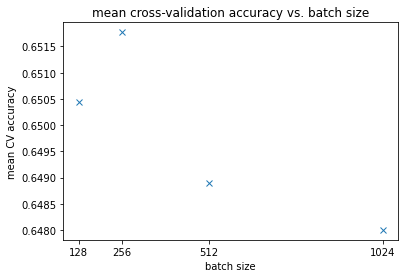

In [15]:
plt.plot(batch_sizes, mean_acc, marker = 'x', linestyle = 'None')
plt.xlabel('batch size')
plt.ylabel('mean CV accuracy')
plt.xticks(batch_sizes)
plt.title('mean cross-validation accuracy vs. batch size')

### b)

In [16]:
time_df = pd.DataFrame()
time_df['batch_sizes'] = batch_sizes
time_df['mean_time of last epoch (ms)'] = mean_time
time_df

,batch_sizes,mean_time of last epoch (ms)
0,128,2.270428
1,256,1.521127
2,512,1.087159
3,1024,0.854794


### c)

The optimal batch size is 256. The mean cross validation accuracy on the final epoch is highest when batch size equals 256.

### d)

When batch size increases, the time taken to train the network on the last epoch decreases. This is because there are more add-multiply operations per second, taking advantages of parallelism and matrix computations. On the other hand, the number of computations per update (of weights, biases) increases.

Before reaching the optimal batch size, the mean cross validation accuracy increases as batch size increases. Increasing beyond the optimal batch size decreases the mean cross validation accuracy. 

Larger batches tend to converge to sharp minima of the training function thus decreasing the model's ability to generalise. On the other hand, small batches tend to favor flat minima that result in better generalization. Poorer generalisation leads to lower mean cross validation accuracy.

### e)

In [17]:
optimal_batch_size = 256

In [18]:
model = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])
    
    
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train,
                    epochs=no_epochs,
                    batch_size=optimal_batch_size,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                    validation_data=(X_test_scaled, y_test))

Epoch 1/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6900 - accuracy: 0.5343 - val_loss: 0.6850 - val_accuracy: 0.5511
Epoch 2/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6834 - accuracy: 0.5523 - val_loss: 0.6819 - val_accuracy: 0.5564
Epoch 3/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6802 - accuracy: 0.5585 - val_loss: 0.6801 - val_accuracy: 0.5597
Epoch 4/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6774 - accuracy: 0.5655 - val_loss: 0.6770 - val_accuracy: 0.5651
Epoch 5/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6747 - accuracy: 0.5704 - val_loss: 0.6743 - val_accuracy: 0.5737
Epoch 6/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6699 - accuracy: 0.5805 - val_loss: 0.6710 - val_accuracy: 0.5751
Epoch 7/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6667 - accuracy: 0.5842 - val_loss: 0.6678 - val_accuracy: 0.5861

Epoch 58/100
499/499 [==============================] - 2s 4ms/step - loss: 0.5842 - accuracy: 0.6767 - val_loss: 0.6003 - val_accuracy: 0.6662
Epoch 59/100
499/499 [==============================] - 2s 4ms/step - loss: 0.5830 - accuracy: 0.6781 - val_loss: 0.5990 - val_accuracy: 0.6674
Epoch 60/100
499/499 [==============================] - 2s 4ms/step - loss: 0.5829 - accuracy: 0.6786 - val_loss: 0.5998 - val_accuracy: 0.6700
Epoch 61/100
499/499 [==============================] - 2s 4ms/step - loss: 0.5810 - accuracy: 0.6797 - val_loss: 0.5989 - val_accuracy: 0.6682
Epoch 62/100
499/499 [==============================] - 2s 4ms/step - loss: 0.5822 - accuracy: 0.6789 - val_loss: 0.5991 - val_accuracy: 0.6678
Epoch 63/100
499/499 [==============================] - 2s 4ms/step - loss: 0.5812 - accuracy: 0.6812 - val_loss: 0.5976 - val_accuracy: 0.6670
Epoch 64/100
499/499 [==============================] - 2s 4ms/step - loss: 0.5804 - accuracy: 0.6804 - val_loss: 0.5983 - val_accuracy:

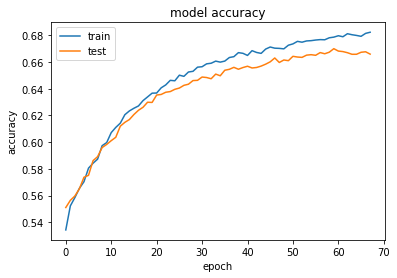

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Question 3

### a)

In [20]:
hidden_units = [64, 128, 256]

In [21]:
def train_hidden():

    cv = KFold(n_splits=no_folds)
    
    acc = []
    for train_idx, test_idx in cv.split(X_train_scaled):    
        
        train_idx_list = train_idx.tolist()
        test_idx_list = test_idx.tolist()
        X_train_cv, X_test_cv = X_train.iloc[train_idx_list], X_train.iloc[test_idx_list]
        X_train_cv_scaled, X_test_cv_scaled = preprocess_dataset(X_train_cv, X_test_cv)
        y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]
        
        accuracy = []
        for no_hidden in hidden_units:
            model = Sequential([
                Dense(no_hidden, activation='relu'),
                Dropout(0.2),
                Dense(128, activation='relu'),
                Dropout(0.2),
                Dense(128, activation='relu'),
                Dropout(0.2),
                Dense(1, activation='sigmoid')])

            model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), 
                          loss='binary_crossentropy', 
                          metrics=['accuracy'])

            history = model.fit(X_train_cv_scaled, y_train_cv,
                        epochs=no_epochs,
                        batch_size=optimal_batch_size,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                        validation_data=(X_test_cv_scaled, y_test_cv))
    
            accuracy.append(history.history['val_accuracy'][-1])
        
        acc.append(accuracy)
    
    cv_acc = np.mean(np.array(acc), axis = 0)

    return cv_acc

In [22]:
mean_acc = train_hidden()
print('Mean accuracy %s' % (mean_acc))
print('Optimal number of hidden units: %d' % hidden_units[np.argmax(mean_acc)])

Epoch 1/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6918 - accuracy: 0.5301 - val_loss: 0.6860 - val_accuracy: 0.5436
Epoch 2/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6854 - accuracy: 0.5461 - val_loss: 0.6840 - val_accuracy: 0.5484
Epoch 3/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6828 - accuracy: 0.5527 - val_loss: 0.6823 - val_accuracy: 0.5518
Epoch 4/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6810 - accuracy: 0.5590 - val_loss: 0.6819 - val_accuracy: 0.5514
Epoch 5/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.5614 - val_loss: 0.6794 - val_accuracy: 0.5619
Epoch 6/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6772 - accuracy: 0.5660 - val_loss: 0.6784 - val_accuracy: 0.5630
Epoch 7/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6757 - accuracy: 0.5715 - val_loss: 0.6765 - val_accuracy: 0.5676

399/399 [==============================] - 1s 4ms/step - loss: 0.6663 - accuracy: 0.5857 - val_loss: 0.6676 - val_accuracy: 0.5885
Epoch 9/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6627 - accuracy: 0.5911 - val_loss: 0.6645 - val_accuracy: 0.5882
Epoch 10/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6590 - accuracy: 0.5961 - val_loss: 0.6630 - val_accuracy: 0.5883
Epoch 11/100
399/399 [==============================] - 2s 5ms/step - loss: 0.6560 - accuracy: 0.6001 - val_loss: 0.6591 - val_accuracy: 0.5991
Epoch 12/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6514 - accuracy: 0.6062 - val_loss: 0.6583 - val_accuracy: 0.5995
Epoch 13/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6491 - accuracy: 0.6104 - val_loss: 0.6561 - val_accuracy: 0.6043
Epoch 14/100
399/399 [==============================] - 2s 5ms/step - loss: 0.6461 - accuracy: 0.6125 - val_loss: 0.6538 - val_accuracy: 0.6102
Epoch 

399/399 [==============================] - 2s 5ms/step - loss: 0.6573 - accuracy: 0.6012 - val_loss: 0.6603 - val_accuracy: 0.5924
Epoch 9/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6512 - accuracy: 0.6079 - val_loss: 0.6577 - val_accuracy: 0.5987
Epoch 10/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6467 - accuracy: 0.6161 - val_loss: 0.6550 - val_accuracy: 0.6011
Epoch 11/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6411 - accuracy: 0.6219 - val_loss: 0.6501 - val_accuracy: 0.6093
Epoch 12/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6365 - accuracy: 0.6265 - val_loss: 0.6450 - val_accuracy: 0.6188
Epoch 13/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6295 - accuracy: 0.6336 - val_loss: 0.6419 - val_accuracy: 0.6226
Epoch 14/100
399/399 [==============================] - 2s 5ms/step - loss: 0.6240 - accuracy: 0.6408 - val_loss: 0.6371 - val_accuracy: 0.6273
Epoch 

399/399 [==============================] - 1s 3ms/step - loss: 0.6516 - accuracy: 0.6089 - val_loss: 0.6555 - val_accuracy: 0.6018
Epoch 22/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6498 - accuracy: 0.6108 - val_loss: 0.6553 - val_accuracy: 0.6079
Epoch 23/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6487 - accuracy: 0.6110 - val_loss: 0.6530 - val_accuracy: 0.6099
Epoch 24/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6476 - accuracy: 0.6145 - val_loss: 0.6520 - val_accuracy: 0.6075
Epoch 25/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6472 - accuracy: 0.6172 - val_loss: 0.6530 - val_accuracy: 0.6083
Epoch 26/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6454 - accuracy: 0.6164 - val_loss: 0.6508 - val_accuracy: 0.6097
Epoch 27/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6446 - accuracy: 0.6189 - val_loss: 0.6498 - val_accuracy: 0.6124
Epoch

399/399 [==============================] - 1s 4ms/step - loss: 0.6169 - accuracy: 0.6473 - val_loss: 0.6299 - val_accuracy: 0.6318
Epoch 27/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6152 - accuracy: 0.6501 - val_loss: 0.6299 - val_accuracy: 0.6326
Epoch 28/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6131 - accuracy: 0.6494 - val_loss: 0.6294 - val_accuracy: 0.6316
Epoch 29/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6128 - accuracy: 0.6523 - val_loss: 0.6290 - val_accuracy: 0.6372
Epoch 30/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6102 - accuracy: 0.6562 - val_loss: 0.6261 - val_accuracy: 0.6371
Epoch 31/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6104 - accuracy: 0.6556 - val_loss: 0.6255 - val_accuracy: 0.6370
Epoch 32/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6077 - accuracy: 0.6559 - val_loss: 0.6251 - val_accuracy: 0.6384
Epoch

Epoch 26/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5781 - accuracy: 0.6831 - val_loss: 0.6092 - val_accuracy: 0.6541
Epoch 27/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5734 - accuracy: 0.6865 - val_loss: 0.6081 - val_accuracy: 0.6559
Epoch 28/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5727 - accuracy: 0.6884 - val_loss: 0.6058 - val_accuracy: 0.6596
Epoch 29/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5693 - accuracy: 0.6917 - val_loss: 0.6039 - val_accuracy: 0.6615
Epoch 30/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5657 - accuracy: 0.6941 - val_loss: 0.6034 - val_accuracy: 0.6623
Epoch 31/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5633 - accuracy: 0.6953 - val_loss: 0.6012 - val_accuracy: 0.6646
Epoch 32/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5617 - accuracy: 0.6970 - val_loss: 0.6010 - val_accuracy:

Epoch 28/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6438 - accuracy: 0.6198 - val_loss: 0.6501 - val_accuracy: 0.6145
Epoch 29/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6448 - accuracy: 0.6169 - val_loss: 0.6520 - val_accuracy: 0.6117
Epoch 30/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6433 - accuracy: 0.6183 - val_loss: 0.6505 - val_accuracy: 0.6136
Epoch 31/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6424 - accuracy: 0.6205 - val_loss: 0.6512 - val_accuracy: 0.6102
Epoch 1/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6910 - accuracy: 0.5351 - val_loss: 0.6841 - val_accuracy: 0.5590
Epoch 2/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6848 - accuracy: 0.5501 - val_loss: 0.6814 - val_accuracy: 0.5594
Epoch 3/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6813 - accuracy: 0.5571 - val_loss: 0.6783 - val_accuracy: 0.

Epoch 54/100
399/399 [==============================] - 1s 4ms/step - loss: 0.5861 - accuracy: 0.6788 - val_loss: 0.6128 - val_accuracy: 0.6510
Epoch 55/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5862 - accuracy: 0.6770 - val_loss: 0.6143 - val_accuracy: 0.6533
Epoch 56/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5842 - accuracy: 0.6793 - val_loss: 0.6107 - val_accuracy: 0.6535
Epoch 1/100
399/399 [==============================] - 2s 5ms/step - loss: 0.6901 - accuracy: 0.5362 - val_loss: 0.6834 - val_accuracy: 0.5557
Epoch 2/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6835 - accuracy: 0.5523 - val_loss: 0.6799 - val_accuracy: 0.5614
Epoch 3/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6798 - accuracy: 0.5605 - val_loss: 0.6765 - val_accuracy: 0.5680
Epoch 4/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6759 - accuracy: 0.5693 - val_loss: 0.6752 - val_accuracy: 0.5

Epoch 55/100
399/399 [==============================] - 2s 5ms/step - loss: 0.5253 - accuracy: 0.7263 - val_loss: 0.5882 - val_accuracy: 0.6757
Epoch 56/100
399/399 [==============================] - 2s 5ms/step - loss: 0.5249 - accuracy: 0.7251 - val_loss: 0.5868 - val_accuracy: 0.6792
Epoch 57/100
399/399 [==============================] - 2s 5ms/step - loss: 0.5244 - accuracy: 0.7266 - val_loss: 0.5863 - val_accuracy: 0.6796
Epoch 58/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5231 - accuracy: 0.7272 - val_loss: 0.5881 - val_accuracy: 0.6743
Epoch 59/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5218 - accuracy: 0.7291 - val_loss: 0.5873 - val_accuracy: 0.6767
Epoch 60/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5198 - accuracy: 0.7296 - val_loss: 0.5832 - val_accuracy: 0.6796
Epoch 61/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5195 - accuracy: 0.7303 - val_loss: 0.5825 - val_accuracy:

Epoch 48/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6284 - accuracy: 0.6377 - val_loss: 0.6382 - val_accuracy: 0.6266
Epoch 49/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6281 - accuracy: 0.6402 - val_loss: 0.6383 - val_accuracy: 0.6274
Epoch 50/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6272 - accuracy: 0.6388 - val_loss: 0.6385 - val_accuracy: 0.6265
Epoch 51/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6265 - accuracy: 0.6400 - val_loss: 0.6382 - val_accuracy: 0.6259
Epoch 1/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6909 - accuracy: 0.5371 - val_loss: 0.6851 - val_accuracy: 0.5509
Epoch 2/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6842 - accuracy: 0.5491 - val_loss: 0.6824 - val_accuracy: 0.5543
Epoch 3/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6804 - accuracy: 0.5593 - val_loss: 0.6803 - val_accuracy: 0.

399/399 [==============================] - 2s 5ms/step - loss: 0.6242 - accuracy: 0.6385 - val_loss: 0.6405 - val_accuracy: 0.6222
Epoch 15/100
399/399 [==============================] - 2s 5ms/step - loss: 0.6197 - accuracy: 0.6435 - val_loss: 0.6349 - val_accuracy: 0.6241
Epoch 16/100
399/399 [==============================] - 2s 5ms/step - loss: 0.6138 - accuracy: 0.6506 - val_loss: 0.6333 - val_accuracy: 0.6257
Epoch 17/100
399/399 [==============================] - 2s 5ms/step - loss: 0.6106 - accuracy: 0.6520 - val_loss: 0.6319 - val_accuracy: 0.6284
Epoch 18/100
399/399 [==============================] - 2s 5ms/step - loss: 0.6058 - accuracy: 0.6581 - val_loss: 0.6302 - val_accuracy: 0.6322
Epoch 19/100
399/399 [==============================] - 2s 5ms/step - loss: 0.6008 - accuracy: 0.6632 - val_loss: 0.6259 - val_accuracy: 0.6327
Epoch 20/100
399/399 [==============================] - 2s 5ms/step - loss: 0.5972 - accuracy: 0.6681 - val_loss: 0.6238 - val_accuracy: 0.6360
Epoch

Epoch 9/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6723 - accuracy: 0.5754 - val_loss: 0.6727 - val_accuracy: 0.5770
Epoch 10/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6702 - accuracy: 0.5769 - val_loss: 0.6705 - val_accuracy: 0.5790
Epoch 11/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6692 - accuracy: 0.5799 - val_loss: 0.6681 - val_accuracy: 0.5841
Epoch 12/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6667 - accuracy: 0.5854 - val_loss: 0.6678 - val_accuracy: 0.5826
Epoch 13/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6651 - accuracy: 0.5867 - val_loss: 0.6662 - val_accuracy: 0.5853
Epoch 14/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6635 - accuracy: 0.5887 - val_loss: 0.6651 - val_accuracy: 0.5927
Epoch 15/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6613 - accuracy: 0.5934 - val_loss: 0.6630 - val_accuracy: 

Epoch 24/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6228 - accuracy: 0.6424 - val_loss: 0.6358 - val_accuracy: 0.6297
Epoch 25/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6211 - accuracy: 0.6449 - val_loss: 0.6344 - val_accuracy: 0.6295
Epoch 26/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6211 - accuracy: 0.6434 - val_loss: 0.6342 - val_accuracy: 0.6325
Epoch 27/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6177 - accuracy: 0.6474 - val_loss: 0.6320 - val_accuracy: 0.6329
Epoch 28/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6138 - accuracy: 0.6515 - val_loss: 0.6287 - val_accuracy: 0.6396
Epoch 29/100
399/399 [==============================] - 1s 4ms/step - loss: 0.6137 - accuracy: 0.6511 - val_loss: 0.6301 - val_accuracy: 0.6337
Epoch 30/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6125 - accuracy: 0.6519 - val_loss: 0.6290 - val_accuracy:

Epoch 20/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5973 - accuracy: 0.6661 - val_loss: 0.6170 - val_accuracy: 0.6499
Epoch 21/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5937 - accuracy: 0.6684 - val_loss: 0.6135 - val_accuracy: 0.6532
Epoch 22/100
399/399 [==============================] - 2s 5ms/step - loss: 0.5892 - accuracy: 0.6734 - val_loss: 0.6106 - val_accuracy: 0.6536
Epoch 23/100
399/399 [==============================] - 2s 5ms/step - loss: 0.5865 - accuracy: 0.6756 - val_loss: 0.6085 - val_accuracy: 0.6572
Epoch 24/100
399/399 [==============================] - 2s 5ms/step - loss: 0.5830 - accuracy: 0.6810 - val_loss: 0.6076 - val_accuracy: 0.6597
Epoch 25/100
399/399 [==============================] - 2s 5ms/step - loss: 0.5798 - accuracy: 0.6834 - val_loss: 0.6051 - val_accuracy: 0.6617
Epoch 26/100
399/399 [==============================] - 2s 5ms/step - loss: 0.5774 - accuracy: 0.6843 - val_loss: 0.6053 - val_accuracy:

Text(0.5, 1.0, 'mean cross-validation accuracy vs. hidden units')

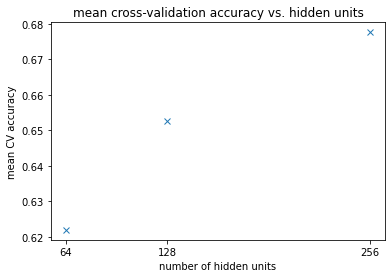

In [23]:
plt.plot(hidden_units, mean_acc, marker = 'x', linestyle = 'None')
plt.xlabel('number of hidden units')
plt.ylabel('mean CV accuracy')
plt.xticks(hidden_units)
plt.title('mean cross-validation accuracy vs. hidden units')

### b)

The optimal number of neurons for the hidden layer is 256. The mean cross validation accuracy on the final epoch is highest when number of hidden-layer neurons equals 256.

### c)

In [24]:
optimal_hidden_unit = 256

In [25]:
model = Sequential([
    Dense(optimal_hidden_unit, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])
    
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train,
                    epochs=no_epochs,
                    batch_size=optimal_batch_size,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                    validation_data=(X_test_scaled, y_test))

Epoch 1/100
499/499 [==============================] - 3s 5ms/step - loss: 0.6889 - accuracy: 0.5405 - val_loss: 0.6835 - val_accuracy: 0.5518
Epoch 2/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6826 - accuracy: 0.5557 - val_loss: 0.6806 - val_accuracy: 0.5562
Epoch 3/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6789 - accuracy: 0.5633 - val_loss: 0.6780 - val_accuracy: 0.5652
Epoch 4/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6750 - accuracy: 0.5707 - val_loss: 0.6740 - val_accuracy: 0.5718
Epoch 5/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6708 - accuracy: 0.5777 - val_loss: 0.6717 - val_accuracy: 0.5763
Epoch 6/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6651 - accuracy: 0.5879 - val_loss: 0.6664 - val_accuracy: 0.5840
Epoch 7/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6599 - accuracy: 0.5953 - val_loss: 0.6608 - val_accuracy: 0.5954

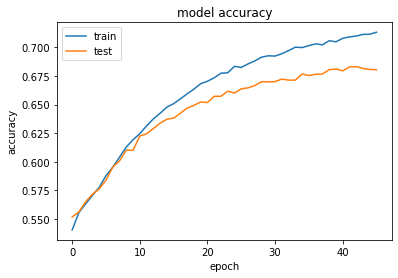

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

### d) 

Dropouts randomly drop neurons (along with their connections) from the networks during training. During training time, the units (neurons) are presented with a probability 𝑝 and presented to the next layer with weight 𝑾. At test time, the weights are always present and presented to the network with weights multiplied by probability 𝑝 (dropout rate). 

The purpose of dropouts is to avoid overfitting by training only a fraction of weights in each iteration. Applying dropouts minimizes redundancy in the network and prevents neurons from co-adapting thereby reducing overfitting.

### e)

Another approach would be regularisation of weights. During overfitting, some weights attain large values to reduce training error, compromising its ability to generalise. Regularisation of weights imposes a penalty term to the cost function. The penalty discourage weights from attaining large values thus improving the model's ability to generalise.

In [27]:
histories={}
histories['model'] = history

In [28]:
from tensorflow.keras.regularizers import l2

regularized_model = Sequential([
    Dense(optimal_hidden_unit, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])
    
regularized_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), 
                          loss='binary_crossentropy', 
                          metrics=['accuracy'])

regularized_history = regularized_model.fit(X_train_scaled, y_train,
                                            epochs=no_epochs,
                                            batch_size=optimal_batch_size,
                                            callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                                            validation_data=(X_test_scaled, y_test))

histories['regularized_model'] = regularized_history

Epoch 1/100
499/499 [==============================] - 3s 5ms/step - loss: 0.7246 - accuracy: 0.5395 - val_loss: 0.7136 - val_accuracy: 0.5538
Epoch 2/100
499/499 [==============================] - 2s 5ms/step - loss: 0.7084 - accuracy: 0.5553 - val_loss: 0.7052 - val_accuracy: 0.5554
Epoch 3/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6989 - accuracy: 0.5612 - val_loss: 0.6964 - val_accuracy: 0.5630
Epoch 4/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6920 - accuracy: 0.5689 - val_loss: 0.6905 - val_accuracy: 0.5660
Epoch 5/100
499/499 [==============================] - 3s 5ms/step - loss: 0.6872 - accuracy: 0.5728 - val_loss: 0.6893 - val_accuracy: 0.5688
Epoch 6/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6826 - accuracy: 0.5809 - val_loss: 0.6838 - val_accuracy: 0.5776
Epoch 7/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6793 - accuracy: 0.5875 - val_loss: 0.6808 - val_accuracy: 0.5839

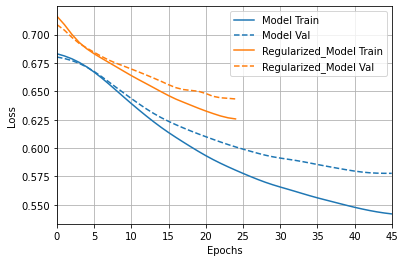

In [29]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

plotter = tfdocs.plots.HistoryPlotter(metric='loss', smoothing_std=10)
plotter.plot(histories)

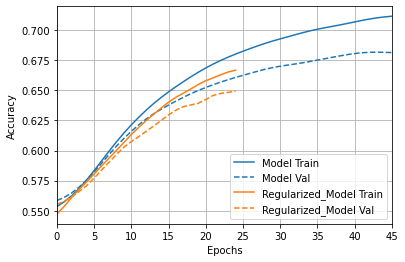

In [30]:
plotter = tfdocs.plots.HistoryPlotter(metric='accuracy', smoothing_std=10)
plotter.plot(histories)

## Question 4

### a)

The wav file is recorded in a **positive manner**.

In [31]:
record_df = pd.read_csv('./new_record.csv') 
record_df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,record.wav,161.499023,1167,97.25,0.455444,0.088477,0.40634,0.088457,0.255579,0.018013,...,-2.778378,144.83191,-18.30352,153.66653,-2.469609,112.56808,-4.447374,141.88397,-11.797533,160.08417


In [32]:
columns_to_drop = ['filename']

record_X_test = record_df.drop(columns_to_drop,axis=1)
record_y_test = [1]

standard_scaler = preprocessing.StandardScaler()
_ = standard_scaler.fit_transform(X_train)
record_X_test_scaled = standard_scaler.transform(record_X_test)

### b)

In [33]:
result = model.predict(record_X_test_scaled)
if result > .5:
    label = 1
else: label = 0

print('Predicted result: %f' % (result))
print('Prediction label on my sample test dataset: %d' % (label))

Predicted result: 0.531395
Prediction label on my sample test dataset: 1


### c)

In [34]:
# Import SHAP library
import shap

# Load JS visualization code to notebook
shap.initjs() # you need this so the plots can be displayed

In [35]:
feature_names = record_X_test.columns

record_X_df = pd.DataFrame(record_X_test_scaled, columns=feature_names)
record_X_df

,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,melspectrogram_mean,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,1.201853,-0.480666,-0.621234,-1.145429,0.295296,-0.854502,0.847864,-0.15168,0.178102,-0.286358,...,0.768217,1.650284,-3.849306,2.645446,0.023818,1.502015,-0.196208,2.544256,-2.739306,3.171681


In [36]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, X_train_scaled)

# Calculate SHAP values for model
shap_values = explainer.shap_values(record_X_test_scaled)

array([[-0.98188845, -0.66652426, -0.50251035, ..., -0.71452695,
         1.13479713, -0.96121638],
       [ 1.8977701 ,  0.30288644,  0.20423714, ...,  0.09663193,
         0.53793319, -0.39115457],
       [ 0.22756814, -0.60304792, -0.74124732, ...,  0.55786375,
         0.85330671,  0.52734208],
       ...,
       [-0.98188845, -0.71222723, -0.9670796 , ...,  2.79995053,
        -0.4349303 ,  2.32059267],
       [-0.12671712,  2.07286078,  1.99583986, ..., -0.43870178,
        -0.55521336, -0.41269647],
       [-0.12671712,  1.05927054,  1.36123826, ...,  0.40455881,
        -1.59415278, -0.4228941 ]])>]
Consider rewriting this model with the Functional API.


keras is no longer supported, please use tf.keras instead.
You have provided over 5k background samples! For better performance consider using smaller random sample.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Consider rewriting this model with the Functional API.
array([[ 1.20185262e+00, -4.80665531e-01, -6.21233599e-01,
        -1.14542853e+00,  2.95296159e-01, -8.54501831e-01,
         8.47864163e-01, -1.51680051e-01,  1.78101988e-01,
        -2.86357918e-01, -2.242947

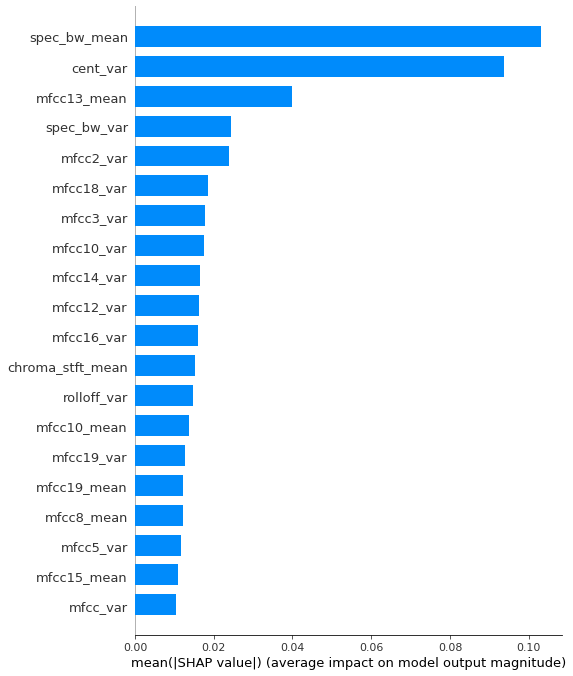

In [38]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = feature_names)

In [37]:
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = feature_names)

In [49]:
print("Base value: %f" % explainer.expected_value[0].numpy())

Base value: 0.525450


The most important features on the model prediction for my test sample are spec_bw_mean and cent_var. spec_bw_mean is the main feature driving up my predicted value while cent_var is the main feature driving it down. 

SHAP allows visualisation of feature attributions as "forces". The goal of SHAP is to explain the prediction by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory where feature values act as players in a coalition. Shapley values tell us how weights are distributed among the features. Each feature value is a force that either increases or decreases the prediction. 

The prediction starts from the baseline which is the average of all predictions or the value of a feature-less model (which generally is the average of the predicted outcome in the training set). From the plot above, the baseline - the average predicted probability - is 0.525450. The predicted value for my speech polarity is 0.531395. Factors such as spec_bw_mean (spectral bandwidth) increased my predicted value while cent_var decreased it.

## Conclusion

From Part A, I learned about early stopping and cross validation. I learned that train variables need to be fit transformed and test variables need to be transformed instead to prevent the model from learning about the test features. I also learned about dropouts and SHAP. SHAP Values is used to interpret the model and understand how the features are related to the output.

Among the parameters tuned, number of hidden neurons in the first hidden layer was most impactful in improving the model performance. Number of hidden neurons affects the number of trainable parameters whereas batch size affects the speed and stability of the learning process. From the plot above, mean cross validation accuracy varied slightly across the batch sizes implying that the learning process is considerably stable regardless of the batch size. Number of trainable parameters affects the model's ability to generalise on unseen data. From the plot above, mean cross validation accuracy fluctuated with differing number of hidden units suggesting that the data is dynamic and the model's ability to generalise is more important. 

An alternative approach is Automatic Speech Recognition (ASR). ASR converts speech into text, after which conventional text-based sentiment detection systems are applied. In an ASR system, speech waveform is converted to acoustic features via speech signal analysis. Then, the acoustic features can be inputted to the Hidden Markov Model (HMM) or DNN to predict the phonemes of the speech. Pronounciation and language model are later involved to formulate words and sentences. Lastly, a decoder combines the information from the various models and search from search graph. After getting the text, Word2Vec can be used to embed the text as inputs to Recursive Neural Network (RNN) for sentiment analysis.

Other tasks that the above approach can be used for are verbal communications with digital devices such as - Siri and Cortana and forwarding of telephone calls in Interactive Voice Response (IVR) systems. A sophisticated ASR system allow the user to enter direct queries or responses, such as a request for driving directions or the telephone number of a hotel in a particular town. ASR also plays a role in customer service by making it possible to reduce the number of human call-center employees. Possible changes to the pipeline would be to add task analysis after obtaining the text from the ASR system where commands can be executed according on user requirements.